In [1]:
# all script for run in another script
#packages
from glob import glob
from os import chdir
from sys import argv
import numpy as np
import matplotlib.pyplot as plt
# import copy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

# Open binary obs files in the obs_netcdftest file

# Change to relevant experiment directory
# chdir(f'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/obs_netcdftest/')

# Glob observation files
files = sorted(glob('/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/obs_netcdftest/*.dat'))

# Define model state dimensions as with files (representing 6 hourly data)
ntime, nlat, nlon, nlev = len(files), 48, 96, 8

# Define fields
fields = [
    {'id': 14593, 'name': 'Surface Pressure [Pa]', 'short': 'ps'},
    {'id': 2819, 'name': 'U-wind [m/s]', 'short': 'u'},
    {'id': 2820, 'name': 'V-wind [m/s]', 'short': 'v'},
    {'id': 3073, 'name': 'Temperature [K]', 'short': 't'},
    {'id': 3330, 'name': 'Specific Humidity [kg/kg]', 'short': 'q'}
]

# Get Gaussian latitudes from GrADS control file
with open('/skydata2/dylanelliott/letkf-hybrid-speedy/common/t30.ctl') as f:
    content = f.readlines()[5]
    lats = [np.float32(lat) for lat in content.split()[3:]]
    lats_py = [float(lat) for lat in content.split()[3:]]

# Define longitudes
lons = np.arange(0, 360, 3.75)

# Define sigma coordinates
sigmas = [0.95, 0.835, 0.685, 0.51, 0.34, 0.2, 0.095, 0.025]

# LOOP THROUGH ALL FILES in obs_netcdftest


# Define model state dimensions
ntime, nlat, nlon, nlev = len(files), 48, 96, 8

# Define fields
fields = [
    {'id': 14593, 'name': 'Surface Pressure [Pa]', 'short': 'ps'},
    {'id': 2819, 'name': 'U-wind [m/s]', 'short': 'u'},
    {'id': 2820, 'name': 'V-wind [m/s]', 'short': 'v'},
    {'id': 3073, 'name': 'Temperature [K]', 'short': 't'},
    {'id': 3330, 'name': 'Specific Humidity [kg/kg]', 'short': 'q'}
]


# define empty array to save each timestep's array in there for below loop
obs_all_timesteps = []
ps_obs_all_timesteps = []

# Loop over all observation files (each one represents one set of 6 hourly observations)
for t, file in enumerate(files):
#     print(file)
    print(f'Processing {t+1} of {ntime} timesteps')
    # Read data from file
    data = np.fromfile(file, dtype=np.float32).byteswap()
#     print(data)
    # Select obs network to read in file
    sparse_network = 12064
    uniform_network = 7250*2
    
    data = np.reshape(data, (uniform_network,8)) 

    # Delete first and last columns - these are used by FORTRAN to give the number of bytes
    # in between, i.e. the length of a row
    data = np.delete(data, [0,7], axis=1)
    
    # First process surface pressure
    ps_obs = data[data[:,0] == fields[0]['id']]
    
    # make array to store the ps obs
    ps_obs_full = np.zeros((48,96))
    
    
    for ob in ps_obs:
        lat_i = np.where(lats == ob[2])[0][0]
        lon_i = np.where(lons == ob[1])[0][0]
        # Convert pressure from hPa to Pa
#         print(lat_i, lon_i, ob[4] ) # hPa 
        ps_obs_full[lat_i, lon_i] =  ob[4] * 100.0 # Pa
#         cubes[0].data[t, lat_i, lon_i] = 100.0*ob[4]

    ps_obs_all_timesteps.append(ps_obs_full)
    
    # make array to store all 3-d obs
    obs_full = np.zeros((4, 48,96,8))
    
    # Now process the other fields
    for i, field in enumerate(fields[1:],1):
        # Get all observations of this field
        obs = data[data[:,0] == field['id']]
        counter = 0 
        for ob in obs:
            lat_i = np.where(lats == ob[2])[0][0]
            lon_i = np.where(lons == ob[1])[0][0]
            
            if field['id'] == 3330:  #account for specific humidity obs being only on the first 4 levels
               obs_full[i-1,lat_i,lon_i,counter%4] = ob[4]
            else:
               obs_full[i-1,lat_i,lon_i,counter%8] = ob[4]
#             print(field, lat_i, lon_i, 100.0*ob[3], ob[4], counter%8)
            counter = counter + 1
    
    # save newly created local array called obs_full to new array containing length of 1460
    # Append the obs_full array of each timestep to the list
    obs_all_timesteps.append(obs_full)
    
    
#             sigma = np.around(100.0*ob[3]/nature_ps.data[t, lat_i, lon_i], decimals=3)
#             lev_i = np.where(sigmas == sigma)[0][0]
    if t + 1 == 50:
            break
# print(obs_all_timesteps[0][1,:,:,7])
# print(len(obs_all_timesteps))
# print(np.shape(obs_all_timesteps))

print('correct for 0s in array by adding nans') 
# Iterate through each element of obs_all_timesteps
for i in range(len(obs_all_timesteps)):
    obs_all_timesteps[i][obs_all_timesteps[i]==0] = np.nan 
    ps_obs_all_timesteps[i][ps_obs_all_timesteps[i]==0] = np.nan
# print(len(obs_all_timesteps))
print(np.shape(obs_all_timesteps))
# make numpy array 
type(obs_all_timesteps)
obs_all_timesteps_array = np.array(obs_all_timesteps)
obs_all_timesteps_array[0]
print('Done.')


Processing 1 of 1460 timesteps
Processing 2 of 1460 timesteps
Processing 3 of 1460 timesteps
Processing 4 of 1460 timesteps
Processing 5 of 1460 timesteps
Processing 6 of 1460 timesteps
Processing 7 of 1460 timesteps
Processing 8 of 1460 timesteps
Processing 9 of 1460 timesteps
Processing 10 of 1460 timesteps
Processing 11 of 1460 timesteps
Processing 12 of 1460 timesteps
Processing 13 of 1460 timesteps
Processing 14 of 1460 timesteps
Processing 15 of 1460 timesteps
Processing 16 of 1460 timesteps
Processing 17 of 1460 timesteps
Processing 18 of 1460 timesteps
Processing 19 of 1460 timesteps
Processing 20 of 1460 timesteps
Processing 21 of 1460 timesteps
Processing 22 of 1460 timesteps
Processing 23 of 1460 timesteps
Processing 24 of 1460 timesteps
Processing 25 of 1460 timesteps
Processing 26 of 1460 timesteps
Processing 27 of 1460 timesteps
Processing 28 of 1460 timesteps
Processing 29 of 1460 timesteps
Processing 30 of 1460 timesteps
Processing 31 of 1460 timesteps
Processing 32 of 

50
(50, 4, 48, 96, 8)
correct for 0s in array by adding nans
50
(50, 4, 48, 96, 8)
Bingo.


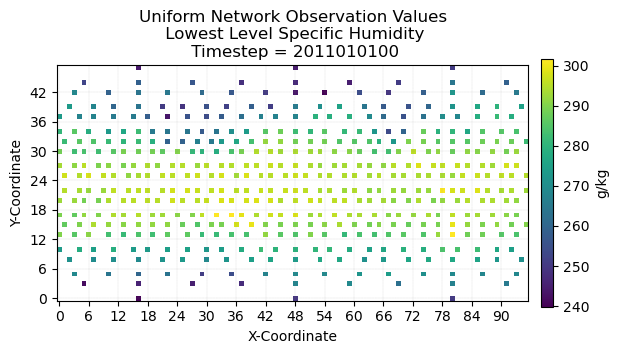

In [2]:
obs_all_timesteps[0][1,:,:,7]
print(len(obs_all_timesteps))
print(np.shape(obs_all_timesteps))

print('correct for 0s in array by adding nans') 
# Iterate through each element of obs_all_timesteps
for i in range(len(obs_all_timesteps)):
    obs_all_timesteps[i][obs_all_timesteps[i]==0] = np.nan        
print(len(obs_all_timesteps))
print(np.shape(obs_all_timesteps))
print('Bingo.')
obs_all_timesteps_array = np.array(obs_all_timesteps)
# plot correct side up with grid so I can select our boys (specific gridpoints by eyeing the graph)

# dimension 1 is index 0 is wind, 1 is wind, 2 is temp, 3 is humid 
# pressure surf is defined in another array
plt.title('Uniform Network Observation Values\n Lowest Level Specific Humidity\n Timestep = 2011010100')
plt.imshow(obs_all_timesteps[0][2,:,:,0],origin='lower') # origin lower fixed it
plt.colorbar(orientation='vertical', fraction=0.025, pad=0.025, label = 'g/kg')
plt.grid(color='grey', linestyle='--', linewidth=.1)
plt.xlabel('X-Coordinate')
plt.xticks(range(0,96,6))
plt.yticks(range(0,48,6))
plt.ylabel('Y-Coordinate')
plt.show()


In [3]:
ps_west_africa_test = ps_obs_all_timesteps[0][20,0] / 100
t_west_africa_test = obs_all_timesteps_array[0][2,20,0,0]
q_west_africa_test = obs_all_timesteps_array[0][3,20,0,0] * 1000
q_west_africa_test

13.015574775636196

In [5]:
T_o = 273.15
RH_test_1 = 26.3 * ps_west_africa_test * q_west_africa_test * ( 1 / (np.exp( (17.67 * (t_west_africa_test - T_o)) / (t_west_africa_test-29.65) )) ) 


In [6]:
print(RH_test_1)

93737.13148069601
